In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [3]:
dataset = load_dataset("EduardoPacheco/FoodSeg103")
train = dataset["train"]

print(f"Total samples: {len(train)}")
print("Example keys:", train[0].keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

Total samples: 4983
Example keys: dict_keys(['image', 'label', 'classes_on_image', 'id'])


## Image Size Analysis

Mean size: 798.4 x 652.3


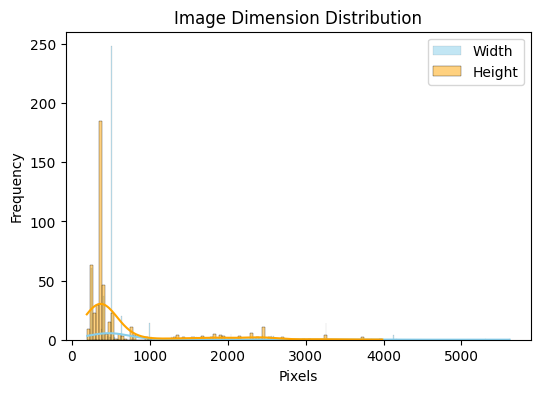

In [4]:
sizes = [train[i]["image"].size for i in range(500)]
widths, heights = zip(*sizes)
print(f"Mean size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")

plt.figure(figsize=(6,4))
sns.histplot(widths, color="skyblue", label="Width", kde=True)
sns.histplot(heights, color="orange", label="Height", kde=True)
plt.legend(); plt.title("Image Dimension Distribution")
plt.xlabel("Pixels"); plt.ylabel("Frequency")
plt.show()

Most images are small, size around 450 * 250. There are some outliers with extreme width small height or vice versa.

## Label Analysis

100%|██████████| 500/500 [00:22<00:00, 21.75it/s]


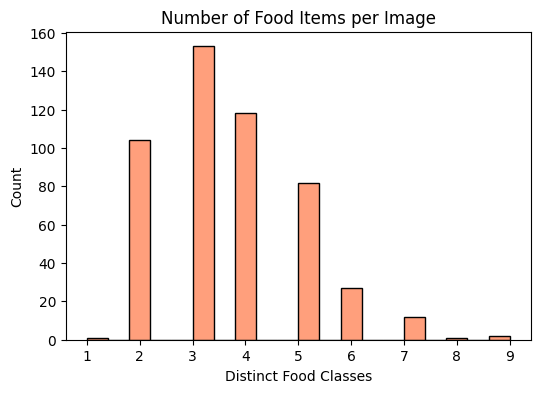

Average food items per image: 3.64


In [7]:
num_classes_per_img = []
for i in tqdm(range(500)):
    mask = np.array(train[i]["label"])
    unique_classes = np.unique(mask)
    num_classes_per_img.append(len(unique_classes) - (1 if 0 in unique_classes else 0))

plt.figure(figsize=(6,4))
sns.histplot(num_classes_per_img, bins=20, kde=False, color="coral")
plt.title("Number of Food Items per Image")
plt.xlabel("Distinct Food Classes")
plt.ylabel("Count")
plt.show()

print(f"Average food items per image: {np.mean(num_classes_per_img):.2f}")

Most images has 2, 3, 4, or 5 food items in the image, and there are extreme outliers like 9 food items.

## Pixel level distribution

100%|██████████| 4000/4000 [02:45<00:00, 24.20it/s]
/tmp/ipython-input-1774700835.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(30), x="ClassID", y="Pixels", palette="viridis")


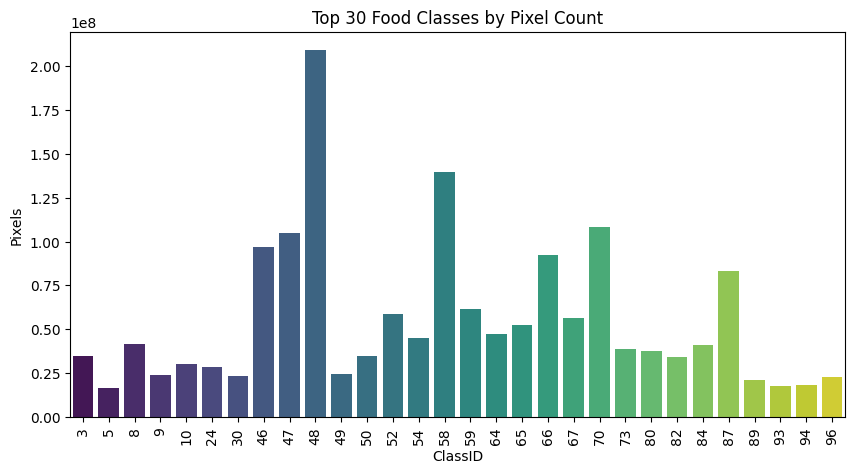

In [10]:
from collections import Counter

class_pixel_counts = Counter()

for i in tqdm(range(4000)):
    mask = np.array(train[i]["label"])
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_pixel_counts[u] += c

class_pixel_counts.pop(0, None)

df = pd.DataFrame(class_pixel_counts.items(), columns=["ClassID", "Pixels"])
df = df.sort_values("Pixels", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=df.head(30), x="ClassID", y="Pixels", palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 30 Food Classes by Pixel Count")
plt.show()

Food item with classID 48 occupies most pixel spaces in pictures. This makes the motivation to use weights to address class imbalance reasonable.

## Reflective Area Analysis

100%|██████████| 4000/4000 [01:11<00:00, 56.04it/s]


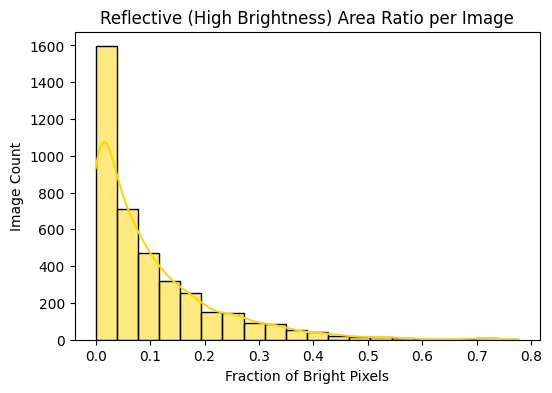

Average bright area ratio: 9.87%


In [12]:
reflect_ratios = []
for i in tqdm(range(4000)):
    img = np.array(train[i]["image"].convert("L"))
    bright_ratio = np.sum(img > 220) / img.size
    reflect_ratios.append(bright_ratio)

plt.figure(figsize=(6,4))
sns.histplot(reflect_ratios, bins=20, color="gold", kde=True)
plt.title("Reflective (High Brightness) Area Ratio per Image")
plt.xlabel("Fraction of Bright Pixels")
plt.ylabel("Image Count")
plt.show()

print(f"Average bright area ratio: {np.mean(reflect_ratios)*100:.2f}%")

There are around 10% of pictures that have high reflective areas, so the motivation to give less weight to those regions is reasonable.

## Visualize some samples

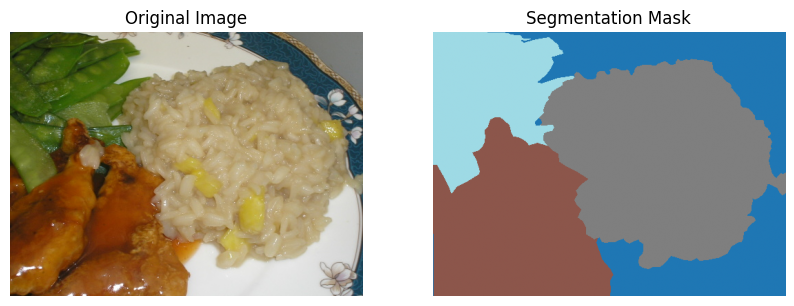

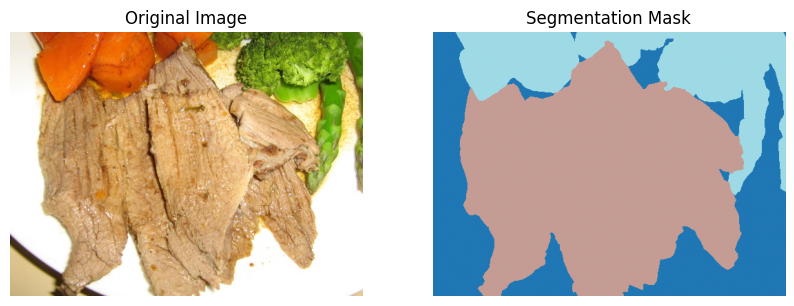

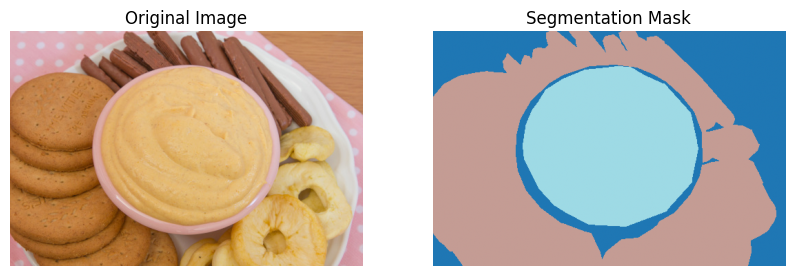

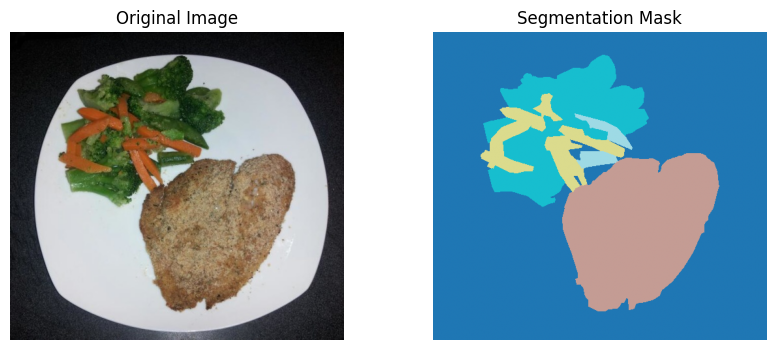

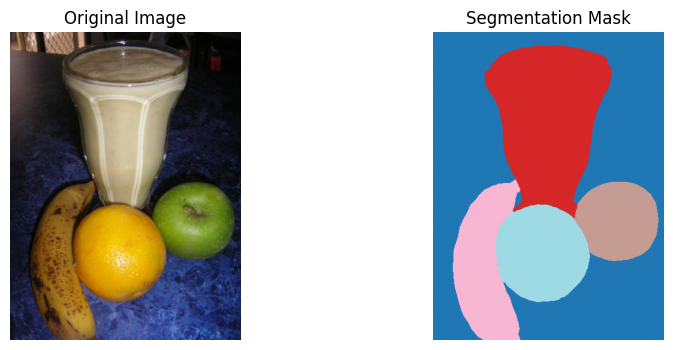

In [14]:
def visualize_sample(idx):
    image = np.array(train[idx]["image"])
    mask = np.array(train[idx]["label"])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(image); plt.title("Original Image"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(mask, cmap="tab20"); plt.title("Segmentation Mask"); plt.axis("off")
    plt.show()

for idx in [0, 3, 10, 15, 22]:
    visualize_sample(idx)